In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib
import numpy

from matplotlib import pyplot
from mt2 import mt2

# Toy MC example
This script generates a kink plot similar to those seen in http://arxiv.org/abs/0711.4008 .

It is intended to illustrate the way that the mass of the invisible daughters of particles
which have been pair-produced can (in principle) be determined by identifying the location
of kink in the boundary of the region of (chi,mt2)-space which is accessible by events.
Specifically: the upper boundary of the filled region of the plot which the script generates
is seen to have a "kink" at the location (chi=50, mt2=100), showing that the generated
invisible daughter particles had a mass of 50 and that the generated parent particles had 
a mass of 100.

It should be noted that the actual kinematics modelled in the program below are not intended
to represent physical reality. For example: the factor 0.01 in the ran_three_direc() function
breaks isotropy in a purely ad-hoc way and here is used to (very crudely) approximate the
bias toward central production seen in supersymmetric events.  The event generation process
used is therefore not Lorentz Invariant and should therefore not be used for any serious
purpose other than, as here, the pedagocial illustration of a kinematic property of
the mt2 variable.

In [2]:
def unif():
    return numpy.random.uniform(-1.0, 1.0)


def ran_three_direc(mag=1):
    while True:
        x, y, z = unif(), unif(), 0.01 * unif()
        psq = x ** 2 + y ** 2 + z ** 2
        if 0.02 < psq < 1:  # Protection against division by zero
            p = numpy.sqrt(psq)
            return mag * x / p, mag * y / p, mag * z / p


def ran_four_mom(mass_squared, mag):
    x, y, z = ran_three_direc(mag=mag)
    return numpy.sqrt(mass_squared + mag ** 2), x, y, z


def boost(bx, by, bz, four_vec):
    bsq = bx ** 2 + by ** 2 + bz ** 2
    gam = 1.0 / numpy.sqrt(1.0 - bsq)
    thing = gam ** 2 / (1 + gam)  # This is the same as (gam-1)/bsq but is safe in the limit bsq->0.
    v0, v1, v2, v3 = four_vec[0], four_vec[1], four_vec[2], four_vec[3]
    return (
        gam * v0 + bx * gam * v1 + by * gam * v2 + bz * gam * v3,
        bx * gam * v0 + (1 + bx * bx * thing) * v1 + (0 + bx * by * thing) * v2 + (0 + bx * bz * thing) * v3,
        by * gam * v0 + (0 + by * bx * thing) * v1 + (1 + by * by * thing) * v2 + (0 + by * bz * thing) * v3,
        bz * gam * v0 + (0 + bz * bx * thing) * v1 + (0 + bz * by * thing) * v2 + (1 + bz * bz * thing) * v3,
    )


def decay(parent_four_mom, m_parent, mv, mi):
    E, px, py, pz = parent_four_mom
    bx, by, bz = px / E, py / E, pz / E  # Velocity beta!
    u = ran_three_direc()
    # print("Unit ", u[0]**2 + u[1]**2 + u[2]**2)
    p = numpy.sqrt((m_parent - mi - mv) * (m_parent + mi - mv) * (m_parent - mi + mv) * (m_parent + mi + mv)) / (
        2 * m_parent)
    v = numpy.sqrt(mv ** 2 + p ** 2), +p * u[0], +p * u[1], +p * u[2]
    i = numpy.sqrt(mi ** 2 + p ** 2), -p * u[0], -p * u[1], -p * u[2]
    v_out = boost(bx, by, bz, v)
    i_out = boost(bx, by, bz, i)
    # print ("E comp ", v_out[0]+i_out[0], E)
    # print ("x comp ", v_out[1]+i_out[1], px)
    # print ()
    return v_out, i_out

In [3]:
def get_mc_data(n_samples: int, n_chi_bins: int):
    """
    Get N data points to plot, where N = n_samples * n_chi_bins data points.
    
    Args:
        n_samples: The number of samples to generate with the toy MC.
        n_chi_bins: The number of bins in invisible particle mass to use.
        
    Returns:
        (N,), (N,)
        Two arrays, the first is chi, the second is MT2.
    """
    m_parent1 = 100
    m_parent2 = 100
    m_vis1 = 10
    m_vis2 = 10
    m_invis = 50

    chi_max = 100.0

    # For every sample, we'll compute MT2 for this range of chi.
    chis = numpy.arange(n_chi_bins + 1) * chi_max / n_chi_bins
    
    data_chi = []
    data_mt2 = []
    for _ in range(n_samples):
    
        parent1 = ran_four_mom(m_parent1 ** 2, numpy.random.uniform(10, 200))
        parent2 = ran_four_mom(m_parent2 ** 2, numpy.random.uniform(10, 200))

        p1, i1 = decay(parent1, m_parent1, m_vis1, m_invis)
        p2, i2 = decay(parent2, m_parent2, m_vis2, m_invis)

        computed_mt2 = mt2(
            m_vis1, p1[0], p1[1],
            m_vis2, p2[0], p2[1],
            i1[0] + i2[0], i1[1] + i2[1],
            chis, chis)  # Symmetric configuration -- same mass for both invisible particles.

        data_chi.append(chis)
        data_mt2.append(computed_mt2)
    
    # Re-arrange and plot data.
    data_chi = numpy.asarray(data_chi).ravel()
    data_mt2 = numpy.asarray(data_mt2).ravel()
    return data_chi, data_mt2


In [4]:
%%time

n_samples = 10000
n_chi_bins = 200

# About 90% of the CPU time here is spent computing MT2
data_chi, data_mt2 = get_mc_data(n_samples, n_chi_bins)

CPU times: user 10.1 s, sys: 29.8 ms, total: 10.1 s
Wall time: 10.1 s


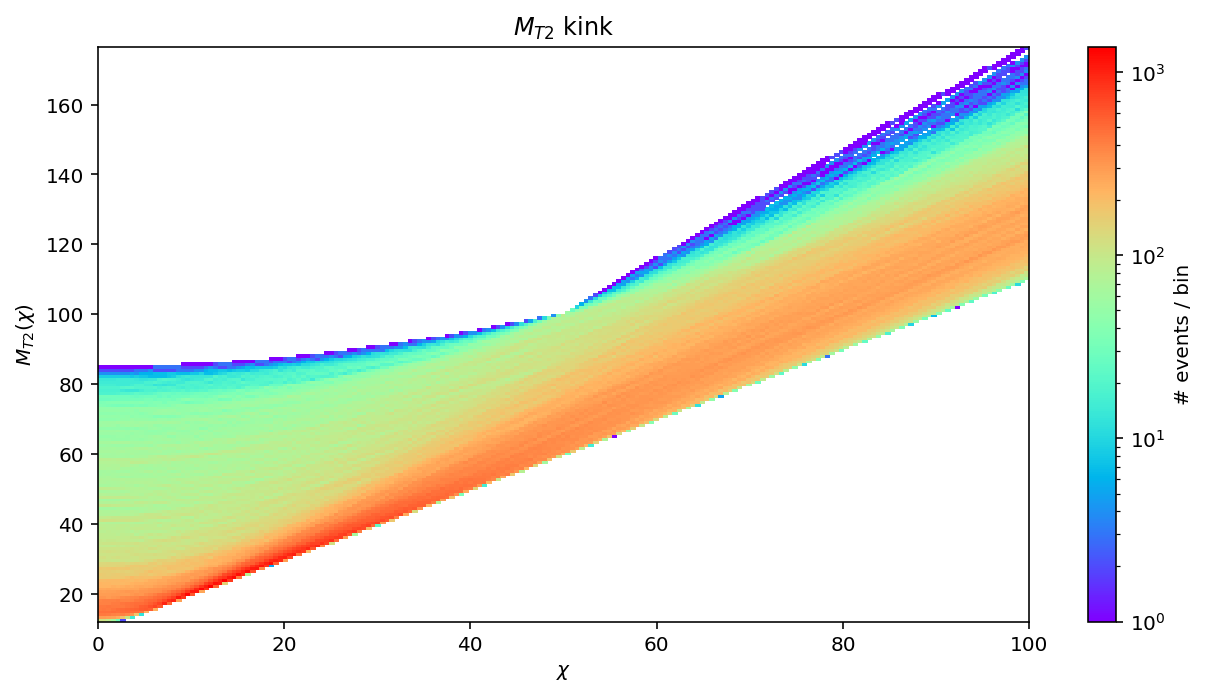

In [5]:
pyplot.figure(figsize=(9, 5))
pyplot.hist2d(data_chi, data_mt2, bins=(n_chi_bins + 1, 200), cmap="rainbow", cmin=1, 
              norm=matplotlib.colors.LogNorm())
pyplot.colorbar().set_label("# events / bin")
pyplot.title("$M_{T2}$ kink")
pyplot.xlabel(r"$\chi$")
pyplot.ylabel(r"$M_{T2}(\chi)$")
pyplot.tight_layout()
pyplot.show()